# Homework 2: Discovery of Frequent Itemsets and Association Rules

This notebook:
1. loads the dataset `data/T10I4D100K.dat` (expected as transactions of item ids),
2. implements A-Priori (candidate generation, pruning, counting),
3. finds frequent itemsets with support ≥ `min_support` (absolute count),
4. prints summary stats and saves results to `frequent_itemsets.csv`.

In [60]:
min_support_apriori = 1000  # min support count for Apriori
max_k = 3  # max size of frequent itemsets
min_support_rules = 1000  # min support count for rules
min_confidence = 0.6  # confidence threshold
top_n_rules_to_print = 30  # top rules to show

DATA_PATH = "data/T10I4D100K.dat"
OUTPUT_CSV_ITEMSETS = "frequent_itemsets.csv"
OUTPUT_CSV_RULES = "association_rules.csv"

# Overview

This implementation performs association rule mining using the Apriori algorithm on transactional data. It discovers frequent itemsets and generates meaningful association rules that reveal patterns in customer purchasing behavior.

## Algorithm Implementation

1. Apriori Algorithm: Efficiently finds frequent itemsets using the downward closure property
2. Parallel Processing: Uses multiprocessing to accelerate support counting
3. Memory Optimization: Employs frozensets and generators for large dataset handling

## Core Functionality

1. Frequent Itemset Mining: Discovers itemsets that meet minimum support thresholds
2. Association Rule Generation: Creates rules with confidence, support, and lift metrics
3. Multi-level Analysis: Supports mining itemsets of varying sizes (1-itemsets to k-itemsets)

In [61]:
from optimized_version import apriori, generate_association_rules, load_transactions

transactions = load_transactions("data/T10I4D100K.dat")
n_transactions = len(transactions)
transactions[:2]

freq_itemsets = apriori(transactions, min_support=1000, max_k=3)

rules = generate_association_rules(freq_itemsets, n_transactions,
                                   min_support=1000, min_confidence=0.6)


## Run Apriori and show results
This cell runs the algorithm with chosen `min_support` and prints:
- time taken
- count of frequent itemsets per size k
- top frequent singletons
It also writes results to `frequent_itemsets.csv`.

In [62]:
from time import time
t0 = time()
freq_itemsets = apriori(transactions, min_support_apriori, max_k = 3)
t1 = time()
print(f"Apriori finished in {t1-t0:.2f}s")

# summary
total_found = sum(len(d) for d in freq_itemsets.values())
print(f"Total frequent itemsets found: {total_found}")
for k in sorted(freq_itemsets):
    print(f" k={k}: {len(freq_itemsets[k])} itemsets")

# top frequent singletons
if 1 in freq_itemsets:
    top_singletons = sorted(freq_itemsets[1].items(), key=lambda x: -x[1])[:10]
    print("\nTop frequent singletons (item,), support:")
    for it, sup in top_singletons:
        print(it, sup)
else:
    print("No frequent singletons at this support.")



Apriori finished in 3.26s
Total frequent itemsets found: 385
 k=1: 375 itemsets
 k=2: 9 itemsets
 k=3: 1 itemsets

Top frequent singletons (item,), support:
(368,) 7828
(529,) 7057
(829,) 6810
(766,) 6265
(722,) 5845
(354,) 5835
(684,) 5408
(217,) 5375
(494,) 5102
(419,) 5057


If we vary the support threshold we can verify how it affects the execution time and the number of frequent itemsets found.

Support=200: time=6.59s, itemsets=7893
Support=400: time=6.50s, itemsets=1768
Support=600: time=6.53s, itemsets=756
Support=800: time=6.60s, itemsets=494
Support=1000: time=3.26s, itemsets=385
Support=1500: time=1.38s, itemsets=237
Support=2000: time=1.28s, itemsets=155


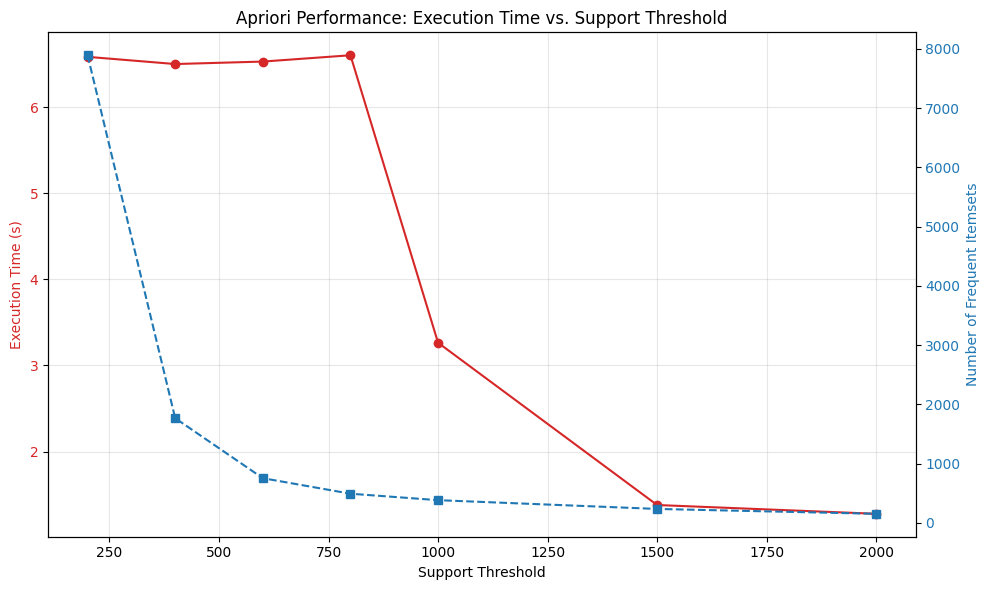

In [63]:
import matplotlib.pyplot as plt
from time import time

# ===============================
# 1. Define the support thresholds to test
# ===============================
supports = [200, 400, 600, 800, 1000, 1500, 2000]

durations = []
n_freq_items = []

# ===============================
# 2. Launch Apriori for every support level
# ===============================
for s in supports:
    t0 = time()
    freq_itemsets = apriori(transactions, min_support=s, max_k=3)
    durations.append(time() - t0)

    # Count how many itemsets were found
    total = sum(len(v) for v in freq_itemsets.values())
    n_freq_items.append(total)

    print(f"Support={s}: time={durations[-1]:.2f}s, itemsets={total}")

# ===============================
# 3. Combined plot of time + number of itemsets
# ===============================
fig, ax1 = plt.subplots(figsize=(10, 6))

# -- First Y-axis: Execution time --
color = 'tab:red'
ax1.set_xlabel('Support Threshold')
ax1.set_ylabel('Execution Time (s)', color=color)
ax1.plot(supports, durations, color=color, marker='o', label='Execution Time')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# -- Second Y-axis: Number of itemsets --
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Frequent Itemsets', color=color)
ax2.plot(supports, n_freq_items, color=color, marker='s', linestyle='--', label='Frequent Itemsets')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Apriori Performance: Execution Time vs. Support Threshold')
fig.tight_layout()

plt.show()

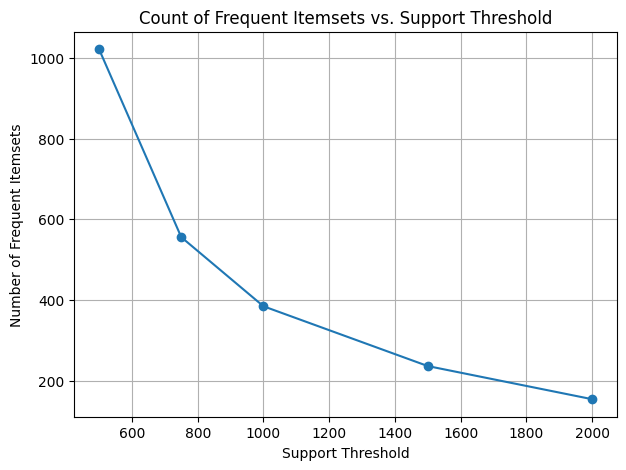

In [64]:
# Define the support thresholds you want to test
support_values = [500, 750, 1000, 1500, 2000]

itemset_counts = []

for s in support_values:
    freq = apriori(transactions, min_support=s, max_k=3)
    count = sum(len(v) for v in freq.values())
    itemset_counts.append(count)

# Plot
plt.figure(figsize=(7,5))
plt.plot(support_values, itemset_counts, marker='o')
plt.title("Count of Frequent Itemsets vs. Support Threshold")
plt.xlabel("Support Threshold")
plt.ylabel("Number of Frequent Itemsets")
plt.grid(True)
plt.show()

## Show top rules
This section displays the association rules generated by the Apriori algorithm applied to the transactional dataset. Association rules reveal meaningful patterns and relationships between items that frequently co-occur in the data.

In [65]:
import pandas as pd

rules_df = pd.read_csv("association_rules.csv")

print("=== ASSOCIATION RULES ===")
display(rules_df.head(30))

print("\n=== TOP RULES (Formattato) ===")
for idx, row in rules_df.head(30).iterrows():
    print(f"{idx+1:2d}. {row['antecedent']} -> {row['consequent']}")
    print(f"     Support: {row['support_count']} ({row['support_frac']})")
    print(f"     Confidence: {row['confidence']}")
    print(f"     Lift: {row['lift']}")
    print()


=== ASSOCIATION RULES ===


,antecedent,consequent,support_count,support_frac,confidence,lift,support_antecedent,support_consequent
0,704 825,39,1035,0.01035,0.939201,22.057338,1102,4258
1,39 704,825,1035,0.01035,0.934959,30.306624,1107,3085
2,39 825,704,1035,0.01035,0.871946,48.603461,1187,1794
3,704,39,1107,0.01107,0.617057,14.491706,1794,4258
4,704,825,1102,0.01102,0.614270,19.911500,1794,3085



=== TOP RULES (Formattato) ===
 1. 704 825 -> 39
     Support: 1035 (0.01035)
     Confidence: 0.939201
     Lift: 22.057338

 2. 39 704 -> 825
     Support: 1035 (0.01035)
     Confidence: 0.934959
     Lift: 30.306624

 3. 39 825 -> 704
     Support: 1035 (0.01035)
     Confidence: 0.871946
     Lift: 48.603461

 4. 704 -> 39
     Support: 1107 (0.01107)
     Confidence: 0.617057
     Lift: 14.491706

 5. 704 -> 825
     Support: 1102 (0.01102)
     Confidence: 0.61427
     Lift: 19.9115



We decide to vary the confidence threshold and analyze how it affects the execution time and the number of rules generated.

In [66]:
confidence_values = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
rule_times = []
n_rules_list = []

print(f"Benchmarking rule generation on {len(confidence_values)} confidence thresholds...")

freq = apriori(transactions, min_support=min_support_apriori, max_k=3)

for c in confidence_values:
    t0 = time()
    rules = generate_association_rules(freq, len(transactions), min_support_rules, c)
    elapsed_time = time() - t0

    rule_times.append(elapsed_time)
    n_rules_list.append(len(rules))

    print(f"Confidence {c}: Found {len(rules):4d} rules in {elapsed_time:.4f} seconds")




Benchmarking rule generation on 6 confidence thresholds...
Confidence 0.1: Found   24 rules in 0.0003 seconds
Confidence 0.2: Found   19 rules in 0.0001 seconds
Confidence 0.4: Found    7 rules in 0.0001 seconds
Confidence 0.6: Found    5 rules in 0.0001 seconds
Confidence 0.8: Found    3 rules in 0.0001 seconds
Confidence 0.9: Found    2 rules in 0.0001 seconds


Confidence 0.1: 0.0005 sec
Confidence 0.2: 0.0001 sec
Confidence 0.4: 0.0001 sec
Confidence 0.6: 0.0001 sec
Confidence 0.8: 0.0001 sec
Confidence 0.9: 0.0001 sec


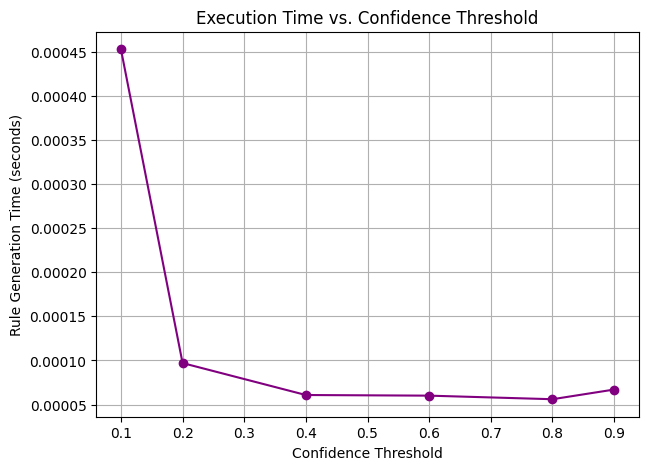

In [67]:
confidence_values = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
rule_times = []

freq = apriori(transactions, min_support=min_support_rules, max_k=3)

for c in confidence_values:
    t0 = time()
    _ = generate_association_rules(freq, len(transactions),
                                   min_support_rules, c)
    rule_times.append(time() - t0)
    print(f"Confidence {c}: {rule_times[-1]:.4f} sec")

plt.figure(figsize=(7,5))
plt.plot(confidence_values, rule_times, marker='o', color='purple')
plt.title("Execution Time vs. Confidence Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Rule Generation Time (seconds)")
plt.grid(True)
plt.show()

Finally, when we look at the number of rules generated, as expected, they decrease with the increase of the confidence threshold as less associations are as strong as required.

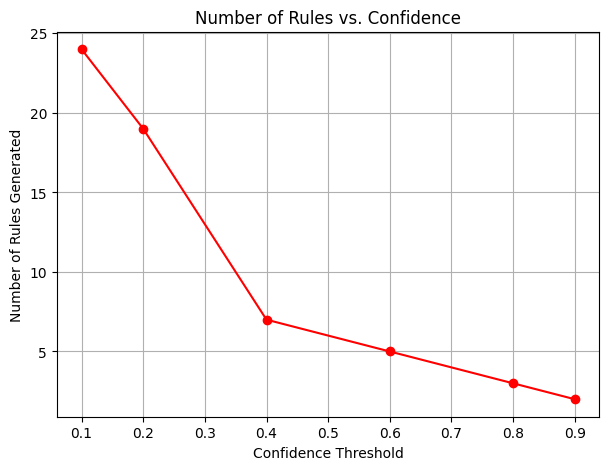

In [68]:
rule_counts = []

for c in confidence_values:
    rules = generate_association_rules(freq, len(transactions),
                                       min_support_rules, c)
    rule_counts.append(len(rules))

plt.figure(figsize=(7,5))
plt.plot(confidence_values, rule_counts, marker='o', color='red')
plt.title("Number of Rules vs. Confidence")
plt.xlabel("Confidence Threshold")
plt.ylabel("Number of Rules Generated")
plt.grid(True)
plt.show()